In [15]:
import torch
import torch.nn as nn
from transformers import CLIPVisionModelWithProjection, ViTForImageClassification, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, LlamaForCausalLM

import sys, os, json, math
from tqdm import tqdm
import numpy as np

from scipy.stats import pearsonr, spearmanr
from scipy.stats import kurtosis

import re
import matplotlib.pyplot as plt
std = 0.012528747320175171

In [16]:
lyr_list = ['q', 'k', 'v', 'o', 'up', 'gate', 'down']
keys = ['proxy_err', 'bpp_loss', 'err', 'mse', 'tr(WHW.T)']
# keys = ['mse']
path = [
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/scaleH_std_ldlq128_scale_cond(col)/size128_encdim1024_M256/lmbda100_result.json',
    '/workspace/Weight_compression/hf_model_comp/comp_qtip/hf/meta-llama--Meta-Llama-3-8B/scaleH_rnorm_ldlq128_scale_cond(col_std)/(uniform31.6)size128_encdim1024_M256/lmbda1000_result.json'
]
label = [
    # 'ql300',
    # 'ql_uniform0_300',
    # 'ql_qmap3_uniform1_lmbda100',
#     'ql_qmap22_uniform0.3_lmbda300',
#     'ql_qmap22_optim',
#     'ql_uniform0_1000',
    # 'ql_rnorm_lmbda100',
    # 'ql_rnorm_trained_lmbda100',
    # 'Original',
    # 'Row-normalized',
    # 'Row-normalized_trained',
    # 'Row-normalized2',
    # 'Row-normalized_trained',
    # 'Col-normalized',
    # 'Layer-normalized',
    # 'Scale cond 128',
    # 'Scale cond 16',
    # 'Scale cond0 128',
    # 'ql',
    # 'rnorm',
    # 'compand_rnorm_trained_rnorm',
    # 'rnorm_trained',
    # 'rnorm_gaussian',
    # 'cnorm_trained',
    # 'lnorm_trained',
    # 'qtip'
    # 'ldlq_rnorm',
    # 'ldlq_rnorm_compand',
    # 'ldlq_rnorm_compand(trained_rnormed)'
    'ldlq_rnorm',
    # 'scale_cond100',
    'scale_cond300',
    # 'scale_cond(trained_no_norm)',
]

data = {}

for l, p in zip(label, path):
    with open(p) as f:
        result = json.load(f)
    data[l] = {}
    for k in keys:
        data[l][k] = {}
        for i in range(32):
            for lyr in lyr_list:
                data[l][k][f'{i}_{lyr}.pt'] = result[f'{i}_{lyr}.pt'][k]

# # qtip
# data['qtip'] = {}
# label.append('qtip')
# for k in keys:
#     data['qtip'][k] = {}
# for i in range(32):
#     for lyr in lyr_list:
#         path = f'/workspace/Weight_compression/hf_model_comp/qtip/ckpt/llama3_8b/ft1/3bit/{i}_{lyr}.pt'
#         # path = f'/workspace/Weight_compression/hf_model_comp/qtip/ckpt/llama2_7b/2bit/{i}_{lyr}.pt'
#         l = torch.load(path)
#         for k in keys:
#             try:
#                 data['qtip'][k][f'{i}_{lyr}.pt'] = l[k]
#                 # data['qtip']['bpp_loss'][f'{i}_{lyr}.pt'] = 3
#             except Exception as e:
#                 # print(e)
#                 pass

In [17]:
def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    return layers

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_model_weight_stats(model, data):
    weights = []
    layers = get_blocks(model)
    
    # 이 부분은 필요에 따라 유지하거나 제거할 수 있습니다.
    lyr_list = ['q', 'k', 'v', 'o', 'up', 'gate', 'down']
    layer_name_map = {
        'self_attn.q_proj': 'q', 'self_attn.k_proj': 'k', 'self_attn.v_proj': 'v',
        'self_attn.o_proj': 'o', 'mlp.up_proj': 'up', 'mlp.gate_proj': 'gate',
        'mlp.down_proj': 'down',
    }
    data['stats'] = {}
    data['stats']['std'] = {}    
    data['stats']['kurt'] = {}    
    
    for i in tqdm(range(len(layers)), desc="Calculating model weight stats"):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            if n in layer_name_map: # Llama3의 linear layer 이름에 맞게 필터링
                w = m.weight.data.detach().float() # 연산을 위해 float으로 변환
                # w = w.reshape(-1, 1024) # 이 reshape는 의도에 따라 조정 필요
                weights.append(w)
                l = layer_name_map[n]
                data['stats']['std'][f'{i}_{l}.pt'] = w.std().item()
                weights_np = w.flatten().cpu().numpy()
                data['stats']['kurt'][f'{i}_{l}.pt'] = kurtosis(weights_np, fisher=True)
    
    # 모든 가중치를 하나의 텐서로 결합
    # weights = torch.cat([w.flatten() for w in weights])
    
    # 평균과 표준편차 계산
    # mean = weights.mean()
    # std = weights.std()
    
    # # --- Kurtosis 계산 추가 ---
    # # Scipy 함수는 NumPy 배열을 사용하므로 변환 필요
    # weights_np = weights.cpu().numpy()
    # # fisher=True는 정규분포의 첨도를 0으로 맞추는 표준 방식입니다.
    # kurt = kurtosis(, fisher=True)
            
    # return mean, std, kurt
    return None, None, None

model_path = "/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Meta-Llama-3-8B"
model = AutoModelForCausalLM.from_pretrained(model_path,
                                                torch_dtype='auto',
                                                low_cpu_mem_usage=True,
                                                local_files_only=True,)
# mean, std, kurt= get_model_weight_stats(model, data)

Loading checkpoint shards: 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


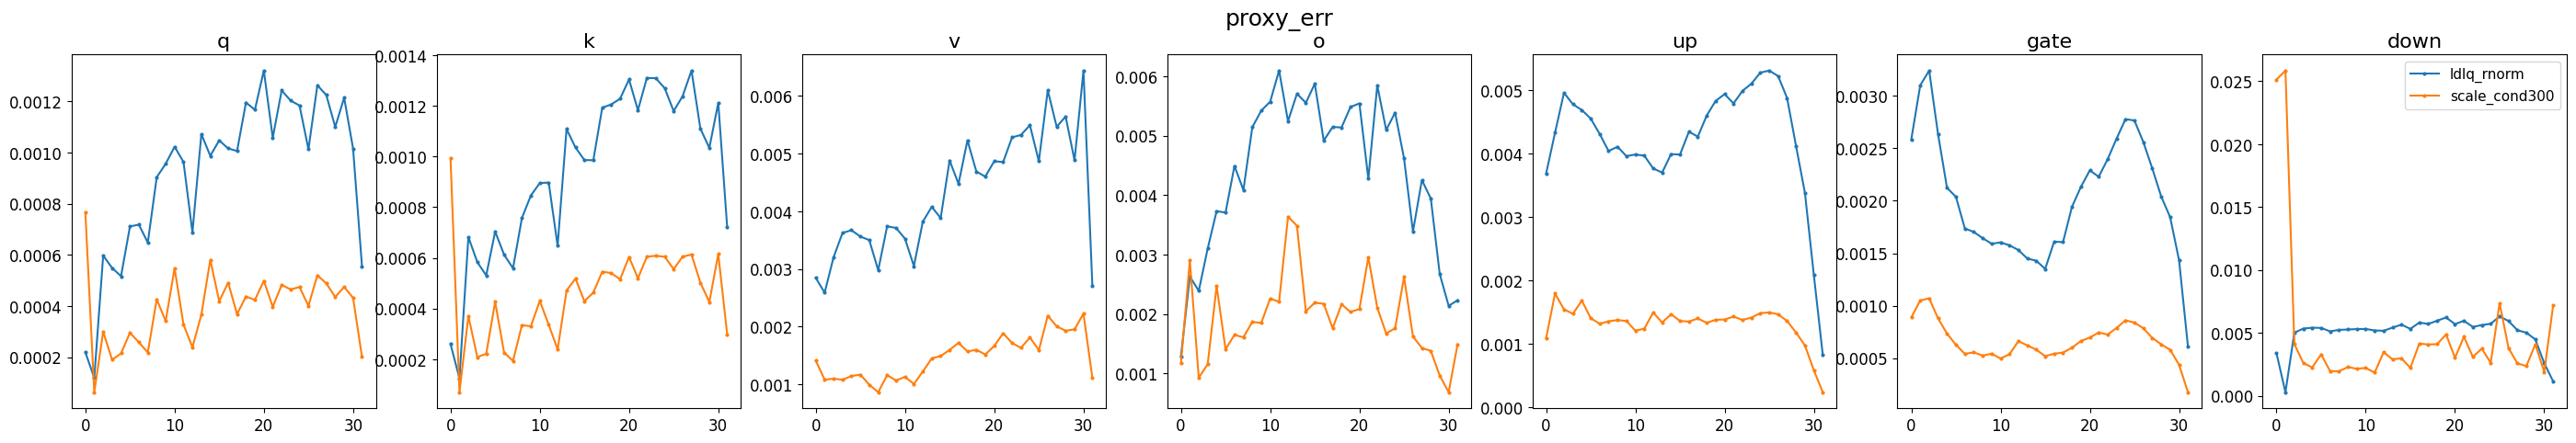

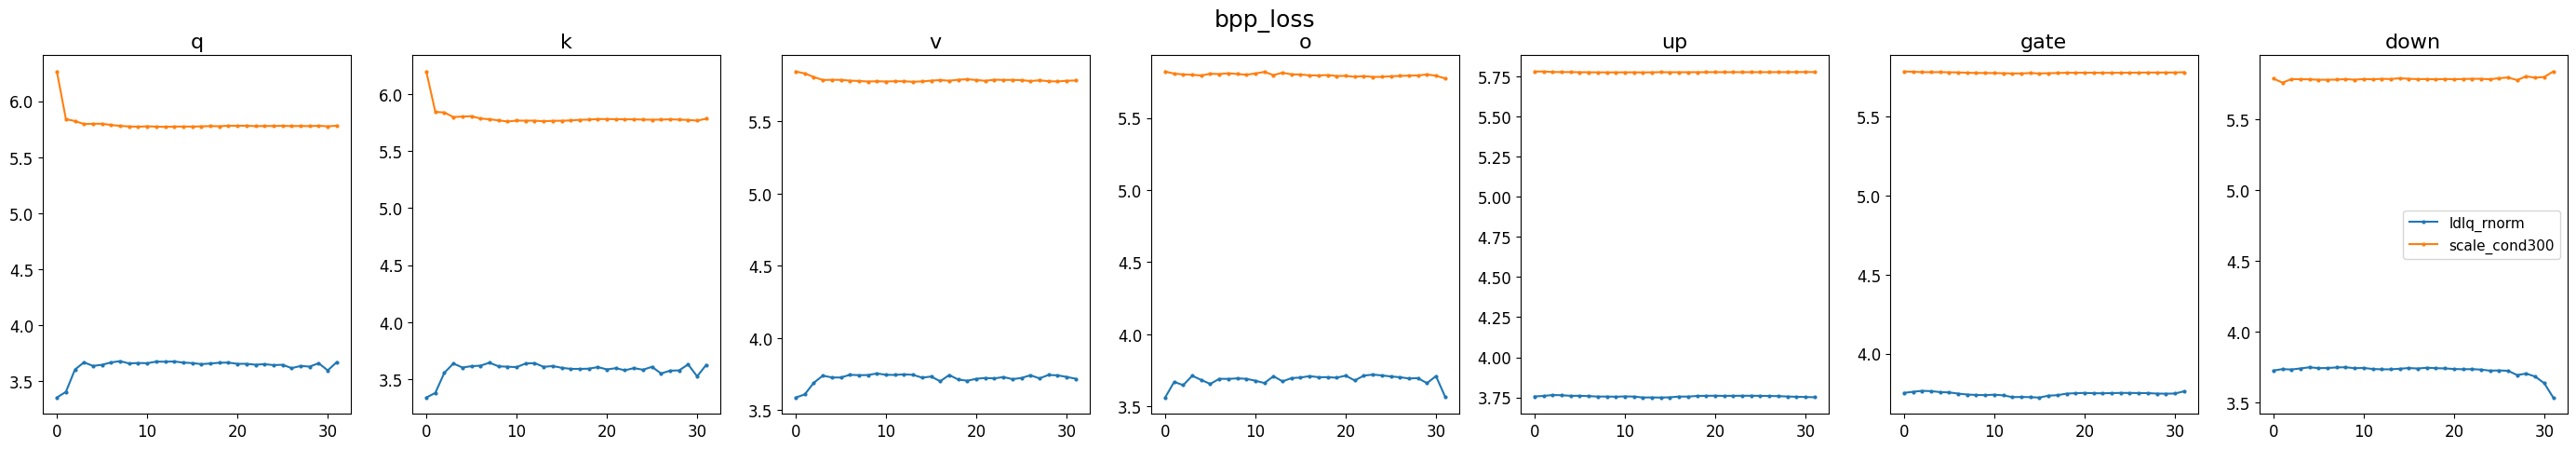

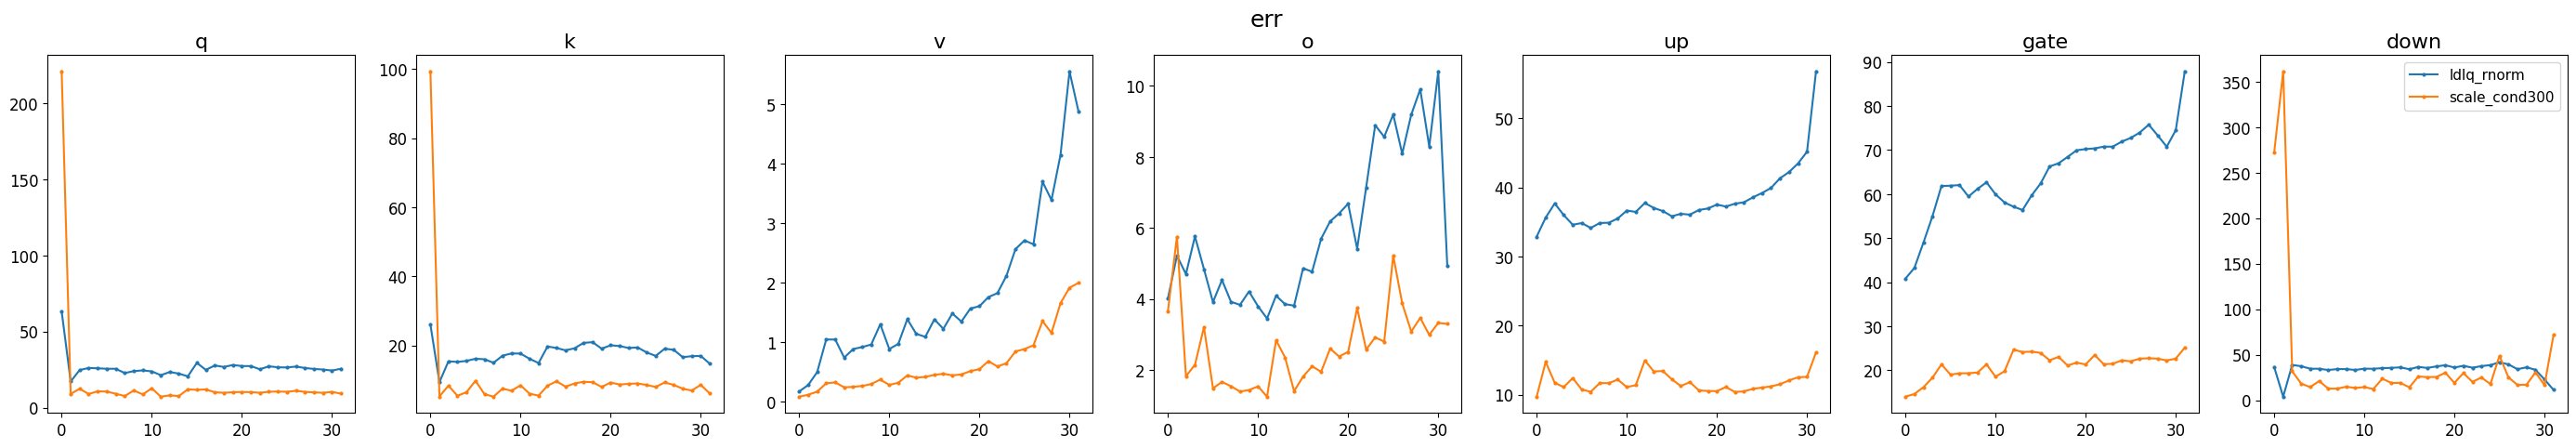

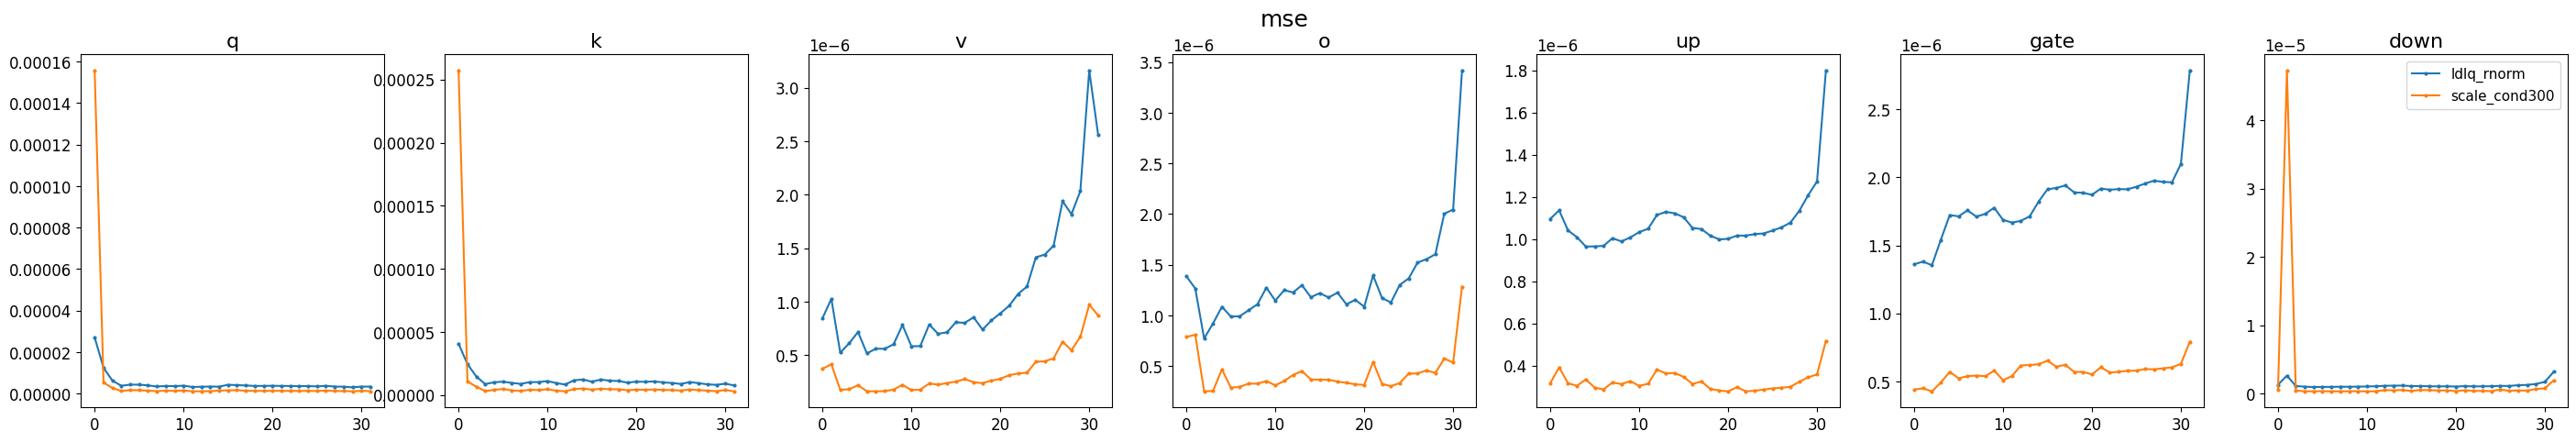

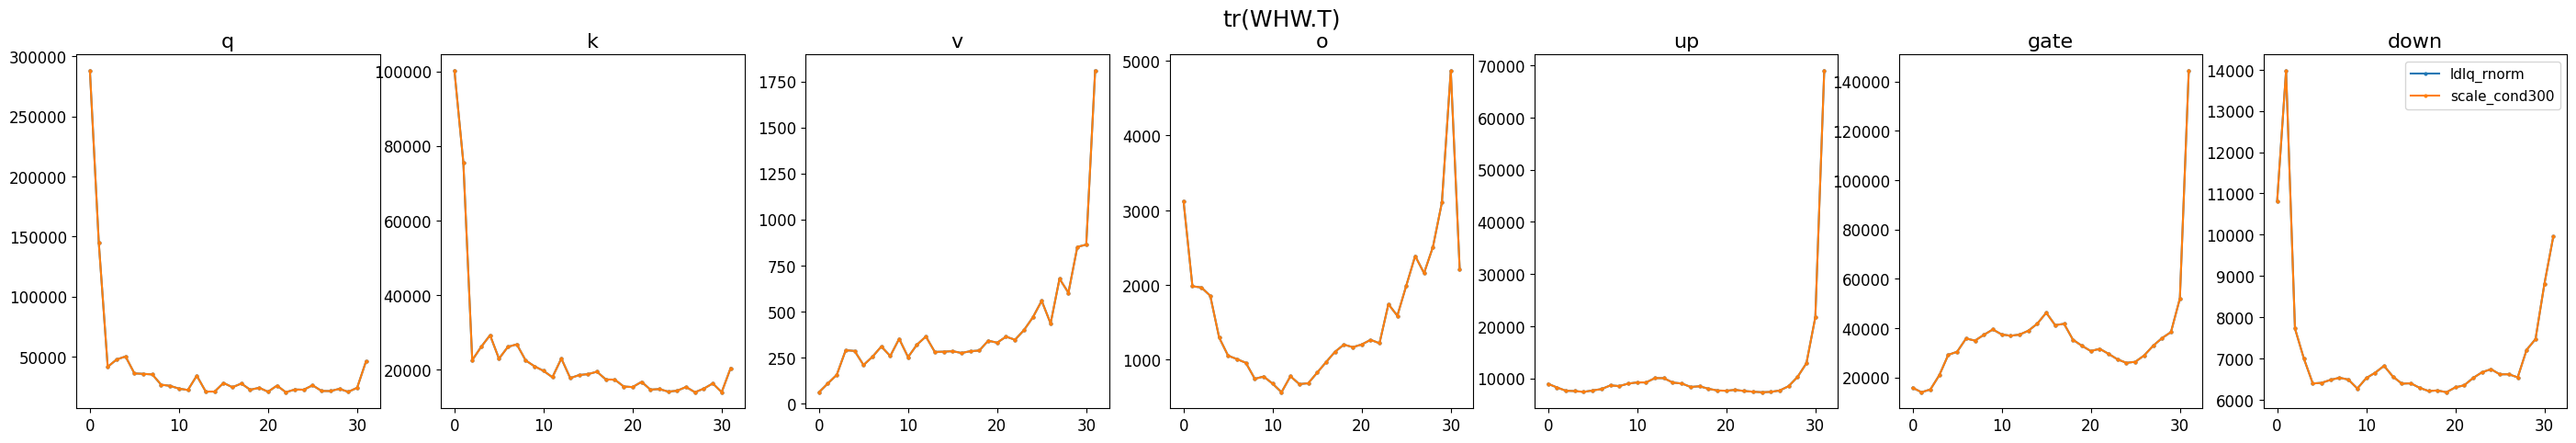

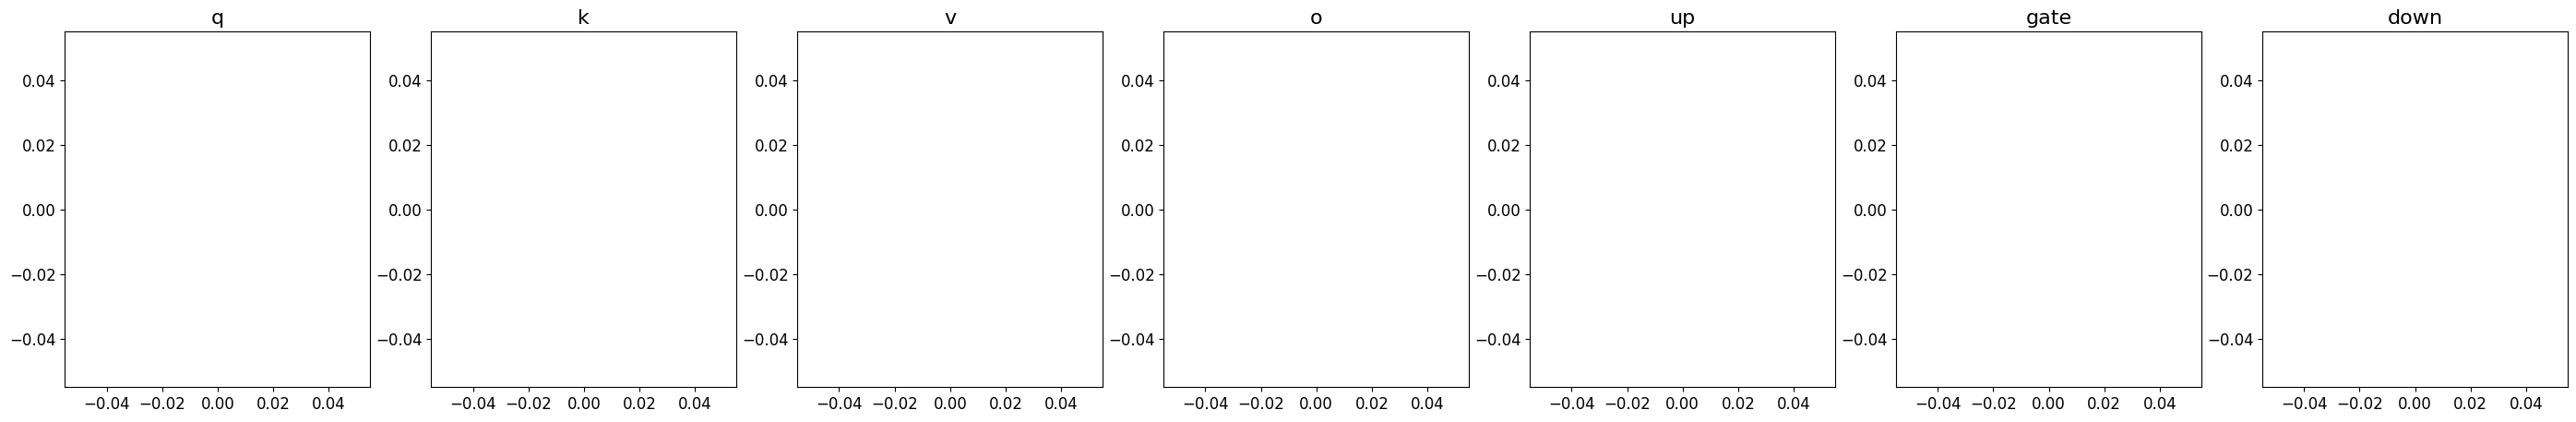

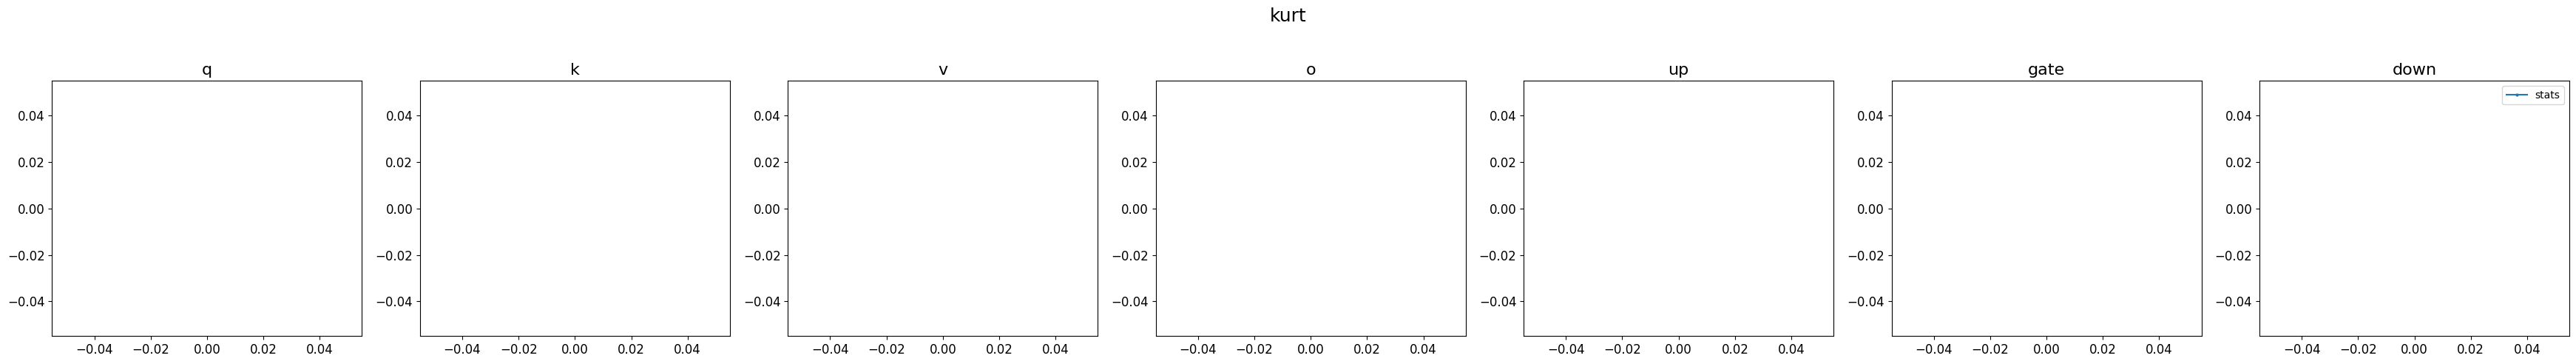

In [18]:
for k in keys:
    fig, axes = plt.subplots(1, 7, figsize=(5*len(lyr_list), 5))
    for i,lyr in enumerate(lyr_list):
        for l in label:
            list = []
            for idx in range(32):
                try:
                    list.append(data[l][k][f'{idx}_{lyr}.pt'])
                except Exception as e:
                    # print(e)
                    pass
            axes[i].plot(list, marker='o', ms='2', label=l)
            axes[i].set_title(lyr)
    plt.suptitle(f'{k}')
    plt.legend()
    plt.show()

for k in ['std', 'kurt']:
    fig, axes = plt.subplots(1, 7, figsize=(5*len(lyr_list), 5))
    for i,lyr in enumerate(lyr_list):
        l = 'stats'
        list = []
        for idx in range(32):
            try:
                list.append(data[l][k][f'{idx}_{lyr}.pt'])
            except Exception as e:
                # print(e)
                pass
        axes[i].plot(list, marker='o', ms='2', label=l)
        axes[i].set_title(lyr)
        # axes[i].axhline(y=std, linestyle='--')

plt.suptitle(f'{k}')
plt.legend(fontsize='small')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


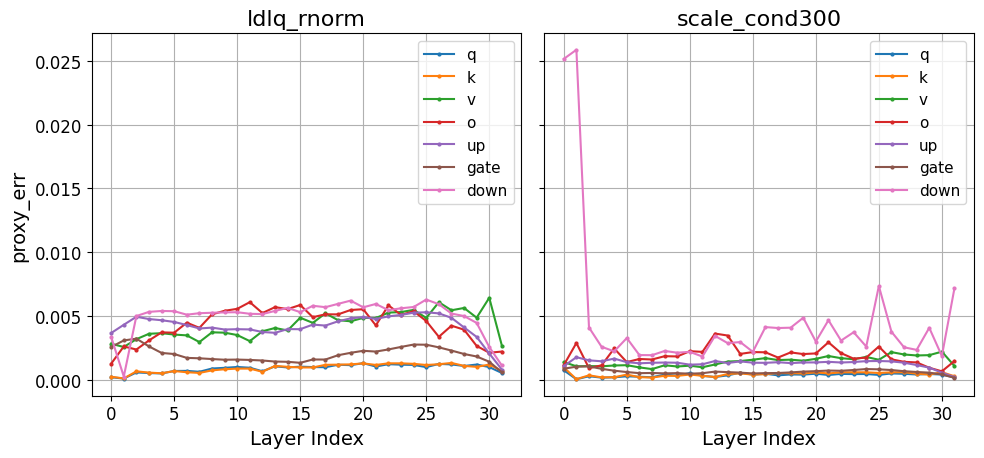

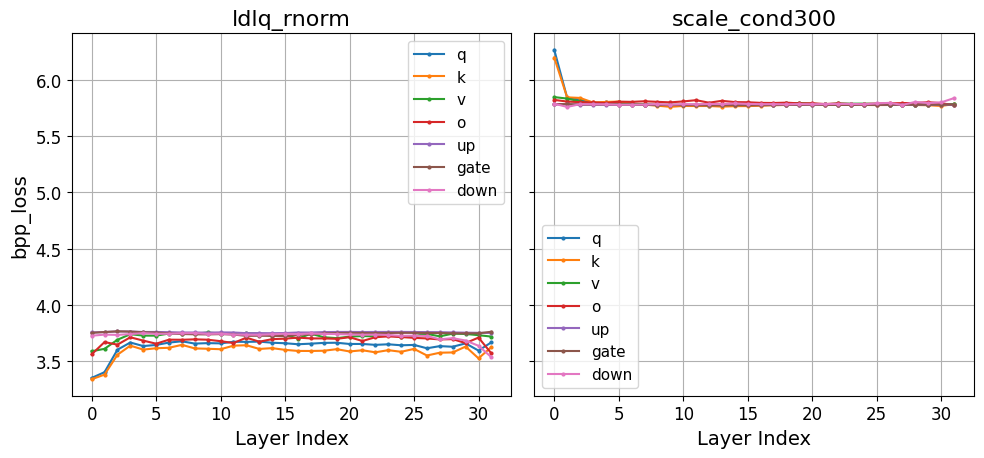

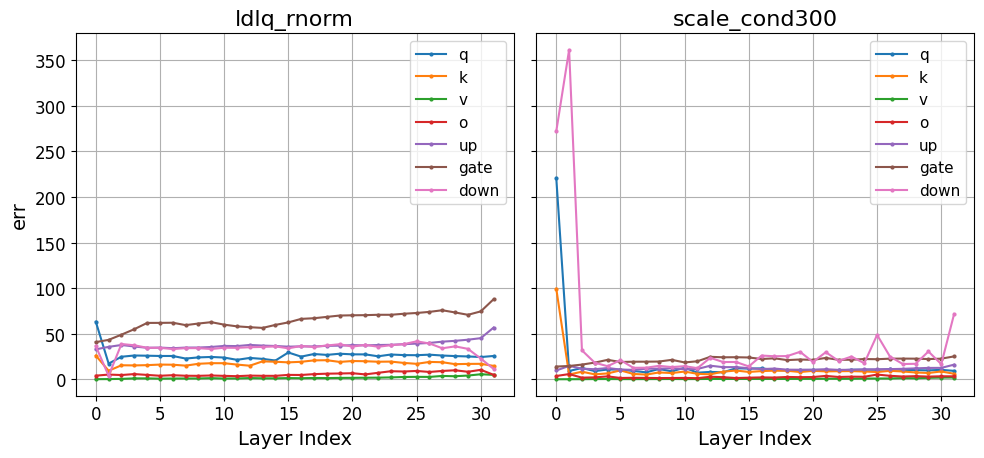

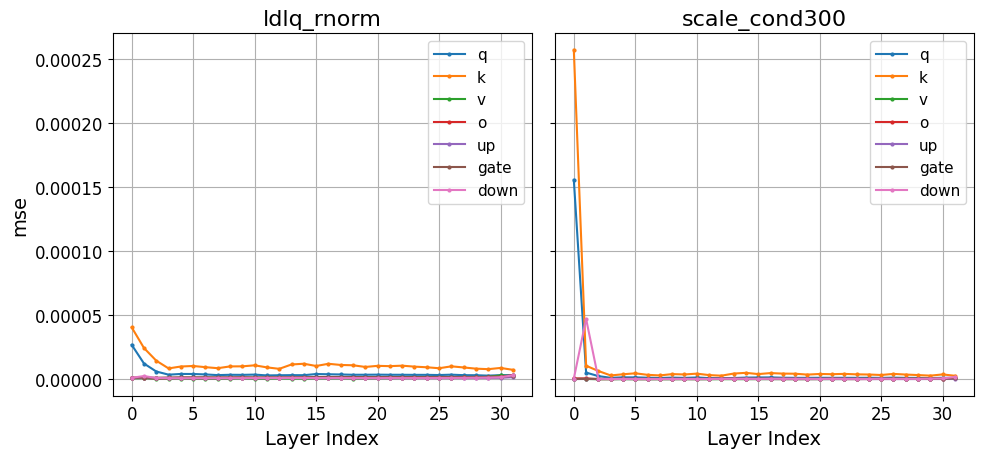

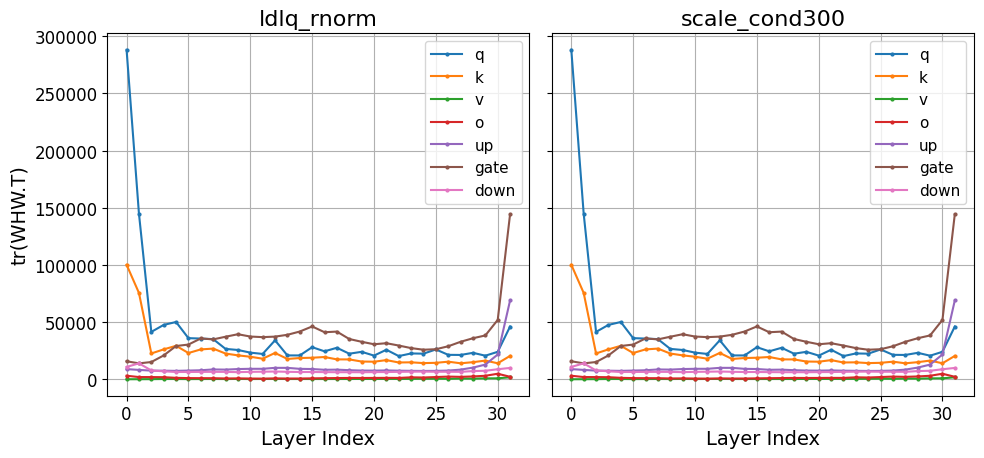

In [19]:
for k in keys:
    # fig, axes = plt.subplots(1, len(label), figsize=(5 * len(keys), 5), sharey=False)
    fig, axes = plt.subplots(1, len(label), figsize=(10, 5), sharey=True)
    
    for i, l in enumerate(label):
        # ax = axes[i] if len(keys) > 1 else axes
        ax = axes[i]
        for lyr in lyr_list:
            values = []
            for idx in range(32):
                try:
                    values.append(data[l][k][f'{idx}_{lyr}.pt'])
                except Exception:
                    pass
            ax.plot(values, marker='o', ms=2, label=lyr)
        
        ax.set_title(f'{l}')
        ax.set_xlabel("Layer Index")
        if i == 0:
            ax.set_ylabel(k)
            # ax.set_ylabel('Proxy loss')
        # ax.legend(fontsize='small')
        ax.legend()
        ax.grid(True)

    # plt.suptitle(f"{k}")
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 11
    plt.rcParams['figure.titlesize'] = 18
    # plt.suptitle('Proxy error per weight matrix')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# l = 'stats'
# k = 'std'
# fig, axes = plt.subplots(figsize=(5, 5))
# for i,lyr in enumerate(lyr_list):
#     list = []
#     for idx in range(32):
#         list.append(data[l][k][f'{idx}_{lyr}.pt'])
#     axes.plot(list, marker='o', ms='2', label=lyr)
# # axes.axhline(y=std, linestyle='--')

# plt.suptitle(f'{k}')
# plt.legend(fontsize='small')
# plt.show()


KeyError: 'stats'

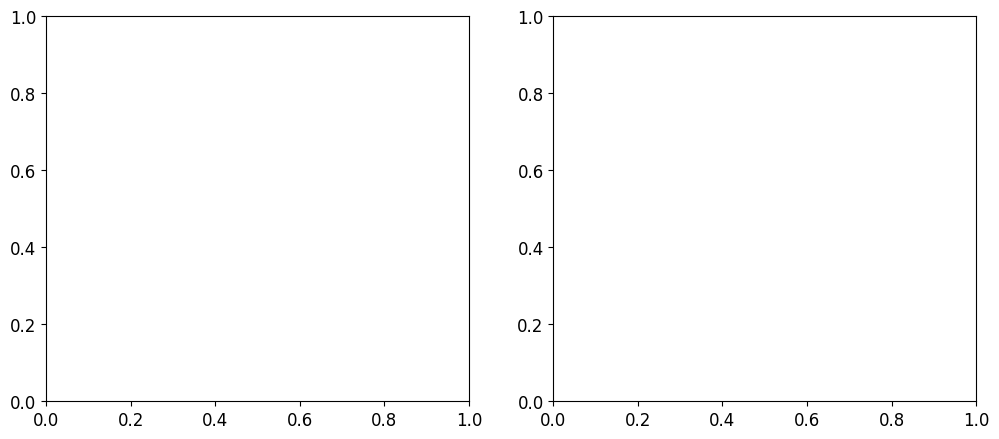

In [20]:
import matplotlib.pyplot as plt

# 1. 1행 2열의 서브플롯 그리드 생성
# figsize는 전체 그림의 크기를 너비 12인치, 높이 5인치로 조절합니다.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- 왼쪽 그래프 (Kurtosis) ---
ax_left = axes[0]  # 왼쪽 축
l = 'stats'
k = 'kurt'

for i, lyr in enumerate(lyr_list):
    # list 변수명 대신 data_list와 같이 다른 이름을 사용하는 것이 좋습니다.
    plot_data = []
    for idx in range(32):
        plot_data.append(data[l][k][f'{idx}_{lyr}.pt'])
    ax_left.plot(plot_data, marker='o', ms='2', label=lyr)

ax_left.set_title('Kurtosis')
ax_left.set_xlabel('Layer index')
ax_left.legend()

# --- 오른쪽 그래프 (JPEG MSE) ---
ax_right = axes[1] # 오른쪽 축
l = 'jpeg'
k = 'mse'

for i, lyr in enumerate(lyr_list):
    plot_data = []
    for idx in range(32):
        plot_data.append(data[l][k][f'{idx}_{lyr}.pt'])
    ax_right.plot(plot_data, marker='o', ms='2', label=lyr)

ax_right.set_title('LIC-TCM MSE') # 제목을 올바르게 수정
ax_right.legend()
ax_right.set_xlabel('Layer index')


# 전체 그림에 대한 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

In [ ]:
s = 0
count = 0
for v in data['tcm']['proxy_err'].values():
    s += v
    count += 1
print(s/count)
# data['qtip']


0.07840943222981878


/tmp/ipykernel_3371788/2165199410.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_components))


KeyError: 'proxy_err'

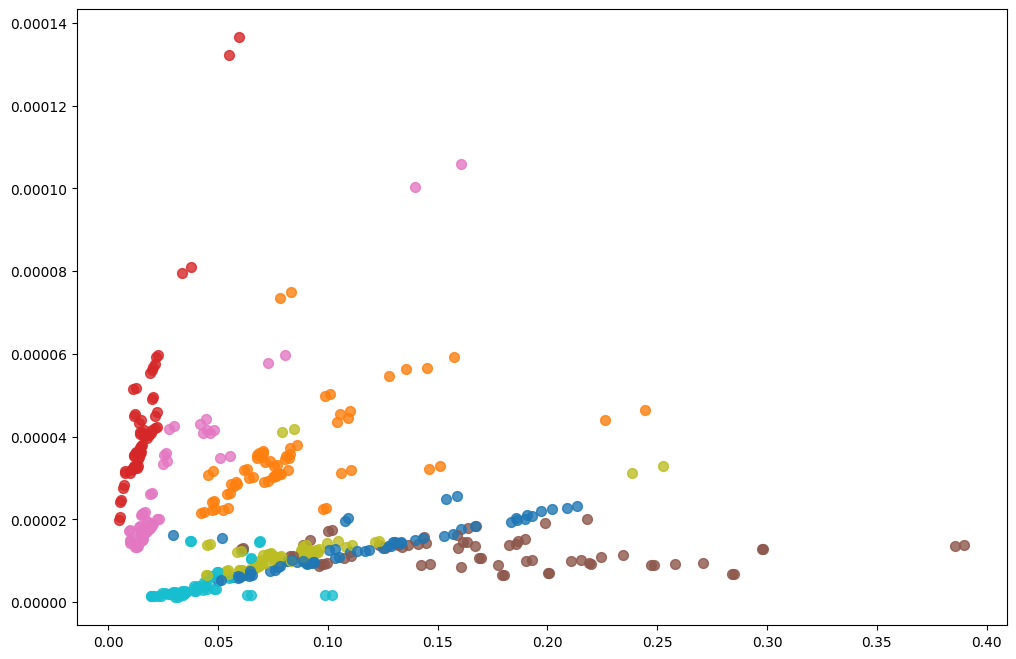

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import collections


fig, ax = plt.subplots(figsize=(12, 8))

for k, v in data.items():
    grouped_data = collections.defaultdict(lambda: {'proxy_err': [], 'mse': []})

    for key, proxy_val in v['proxy_err'].items():
        if key in v['mse']:
            # '0_q.pt'에서 'q' 부분만 추출
            component = key.split('_')[1].split('.')[0]
            
            # 해당 구성요소에 데이터 추가
            grouped_data[component]['proxy_err'].append(proxy_val)
            grouped_data[component]['mse'].append(v['mse'][key])

    # 2. 플롯 생성


    # 각 구성요소에 대한 색상 지정
    # 'tab10' 컬러맵을 사용해 자동으로 색을 할당합니다.
    unique_components = sorted(grouped_data.keys())
    colors = plt.cm.get_cmap('tab10', len(unique_components))
    color_map = {comp: colors(i) for i, comp in enumerate(unique_components)}

    # 그룹화된 데이터로 스캐터 플롯 그리기
    for component, values in grouped_data.items():
        ax.scatter(
            values['proxy_err'], 
            values['mse'], 
            color=color_map[component],
            label=component,
            alpha=0.8,  # 점의 투명도
            s=50,        # 점의 크기
        )

# 3. 플롯 스타일링
# 로그 스케일 적용하여 데이터 분포를 명확하게 확인
ax.set_xscale('log')
ax.set_yscale('log')

# 제목 및 라벨 설정
ax.set_title('MSE vs. Proxy Error (Log-Log Scale)', fontsize=16)
ax.set_xlabel('Proxy Error', fontsize=12)
ax.set_ylabel('MSE', fontsize=12)

# 범례(legend) 및 그리드 추가
ax.legend(title='Component', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 레이아웃을 타이트하게 조정
plt.tight_layout()

# 플롯 보여주기
plt.show()

/tmp/ipykernel_1163022/2005357292.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(experiment_names))


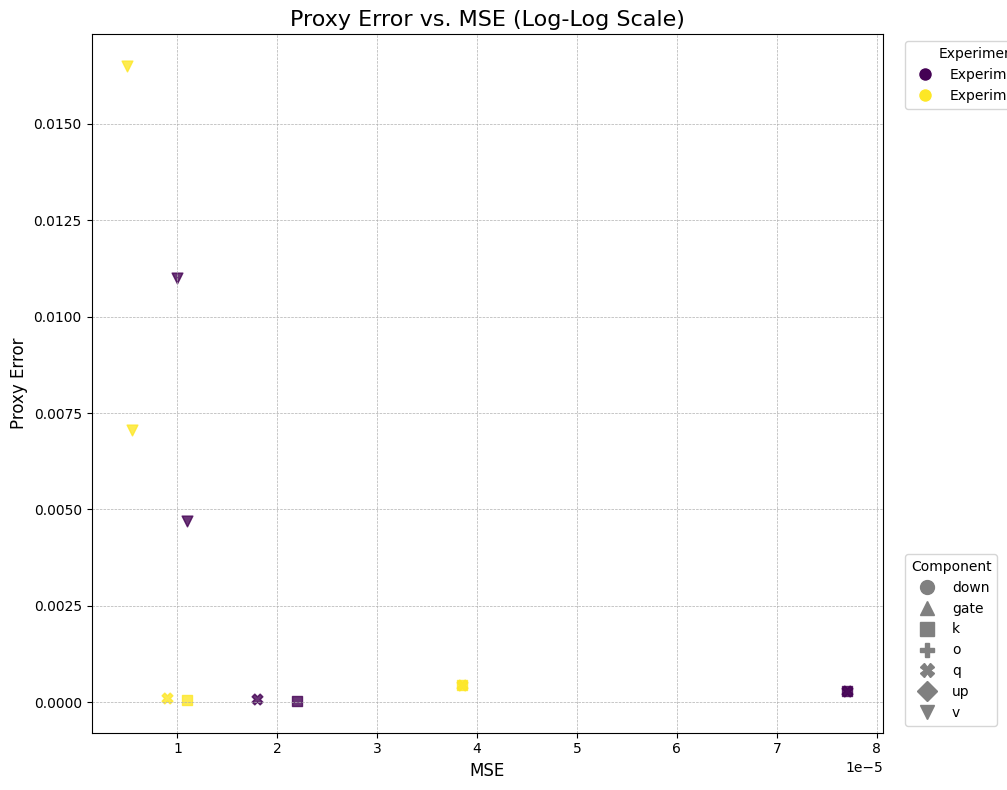

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import collections
from matplotlib.lines import Line2D

# --- 예시 데이터 ---
# 실제 데이터는 이 구조에 맞게 채워주세요.
# 두 개의 다른 실험 결과가 있다고 가정합니다.
def generate_mock_data(offset=0):
    # 이전 질문의 데이터를 기반으로 가상 데이터 생성
    original_data = {'proxy_err': {'0_q.pt': 7.6e-05, '0_k.pt': 3.3e-05, '0_v.pt': 4.7e-03, '1_q.pt': 3.0e-04, '1_k.pt': 2.9e-04, '1_v.pt': 1.1e-02}, 'mse': {'0_q.pt': 1.8e-05, '0_k.pt': 2.2e-05, '0_v.pt': 1.1e-05, '1_q.pt': 7.7e-05, '1_k.pt': 7.7e-05, '1_v.pt': 1.0e-05}}
    new_data = {'proxy_err': {}, 'mse': {}}
    for k, v in original_data['proxy_err'].items():
        new_data['proxy_err'][k] = v * (1 + offset)
    for k, v in original_data['mse'].items():
        new_data['mse'][k] = v * (1 - offset)
    return new_data

# 'data' 변수에 여러 실험 결과를 딕셔너리 형태로 담습니다.
data = {
    "Experiment_A": generate_mock_data(offset=0),
    "Experiment_B": generate_mock_data(offset=0.5)
}
# --- 예시 데이터 끝 ---


# 1. 시각적 요소 사전 정의
# 가중치(component) 타입에 따라 다른 마커(모양)를 지정
unique_components = sorted(['q', 'k', 'v', 'o', 'up', 'gate', 'down'])
markers = ['o', '^', 's', 'P', 'X', 'D', 'v']
marker_map = {comp: markers[i % len(markers)] for i, comp in enumerate(unique_components)}

# 실험(결과)에 따라 다른 색상 지정
experiment_names = sorted(data.keys())
colors = plt.cm.get_cmap('viridis', len(experiment_names))
color_map = {name: colors(i) for i, name in enumerate(experiment_names)}

# 2. 플롯 생성
fig, ax = plt.subplots(figsize=(12, 8))

# 3. 데이터 플로팅 (실험별 루프)
for exp_name, exp_data in data.items():
    # 현재 실험에 해당하는 색상 가져오기
    color = color_map[exp_name]

    # 가중치 타입별로 데이터 그룹화
    grouped_components = collections.defaultdict(lambda: {'proxy_err': [], 'mse': []})
    for key, proxy_val in exp_data['proxy_err'].items():
        if key in exp_data['mse']:
            component = key.split('_')[1].split('.')[0]
            grouped_components[component]['proxy_err'].append(proxy_val)
            grouped_components[component]['mse'].append(exp_data['mse'][key])

    # 그룹화된 데이터를 점으로 그리기 (가중치 타입별 루프)
    for component, values in grouped_components.items():
        # 현재 가중치 타입에 해당하는 마커 가져오기
        marker = marker_map.get(component, 'o') # 혹시 모를 키에 대비
        
        # X축과 Y축을 바꿔서 플로팅
        ax.scatter(
            values['mse'],          # X축: MSE
            values['proxy_err'],    # Y축: Proxy Error
            color=color,
            marker=marker,
            alpha=0.8,
            s=60  # 점 크기
        )

# 4. 플롯 스타일링
# ax.set_xscale('log')
# ax.set_yscale('log')

# 제목 및 라벨 변경
ax.set_title('Proxy Error vs. MSE (Log-Log Scale)', fontsize=16)
ax.set_xlabel('MSE', fontsize=12)
ax.set_ylabel('Proxy Error', fontsize=12)

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 5. 두 종류의 정보를 담은 범례(Legend) 생성
# 색상에 대한 범례 (실험 구분)
color_handles = [Line2D([0], [0], marker='o', color='w', label=name, 
                        markerfacecolor=c, markersize=10) 
                 for name, c in color_map.items()]
legend1 = ax.legend(handles=color_handles, title="Experiment", loc='upper left', bbox_to_anchor=(1.02, 1))
ax.add_artist(legend1) # 첫 번째 범례를 그림에 고정

# 마커에 대한 범례 (가중치 타입 구분)
marker_handles = [Line2D([0], [0], marker=m, color='gray', label=name, 
                         linestyle='None', markersize=10) 
                  for name, m in marker_map.items()]
ax.legend(handles=marker_handles, title="Component", loc='lower left', bbox_to_anchor=(1.02, 0))

plt.tight_layout(rect=[0, 0, 0.85, 1]) # 범례가 잘리지 않도록 레이아웃 조정
plt.show()